In [1]:
# utils
import os 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# torch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_directory = 'Dataset'
train, test = 'Training', 'Testing'
target_size = (224, 224)
random_state = 42
batch_size = 32
num_classes = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
label_map = {
    'notumor': 0,        
    'glioma': 1,         
    'meningioma': 2,     
    'pituitary': 3       
}

In [3]:
categories = os.listdir(base_directory+'/'+train)
print(categories)

['glioma', 'meningioma', 'notumor', 'pituitary']


# Data Preparation and Exploratory Data Analysis

In [15]:
def display_images(dataset_type, num_images=4, image_size=(224, 224)):
    
    dataset_path = os.path.join(base_directory, dataset_type)

    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_filenames = random.sample(os.listdir(category_path), num_images)  # Select random images
        
        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    plt.show()

In [17]:
def plot_class_distribution(dataset_type):
    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()

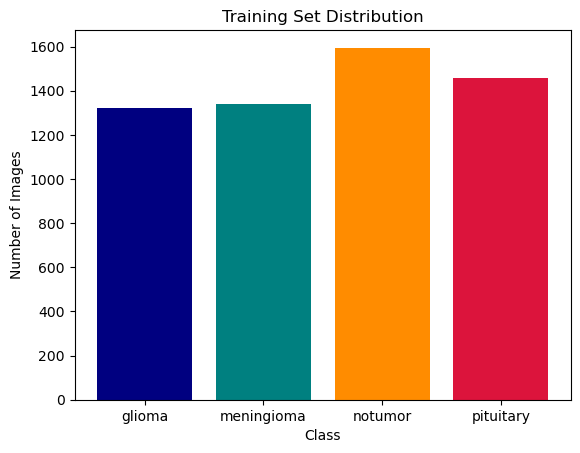

In [19]:
plot_class_distribution(train)

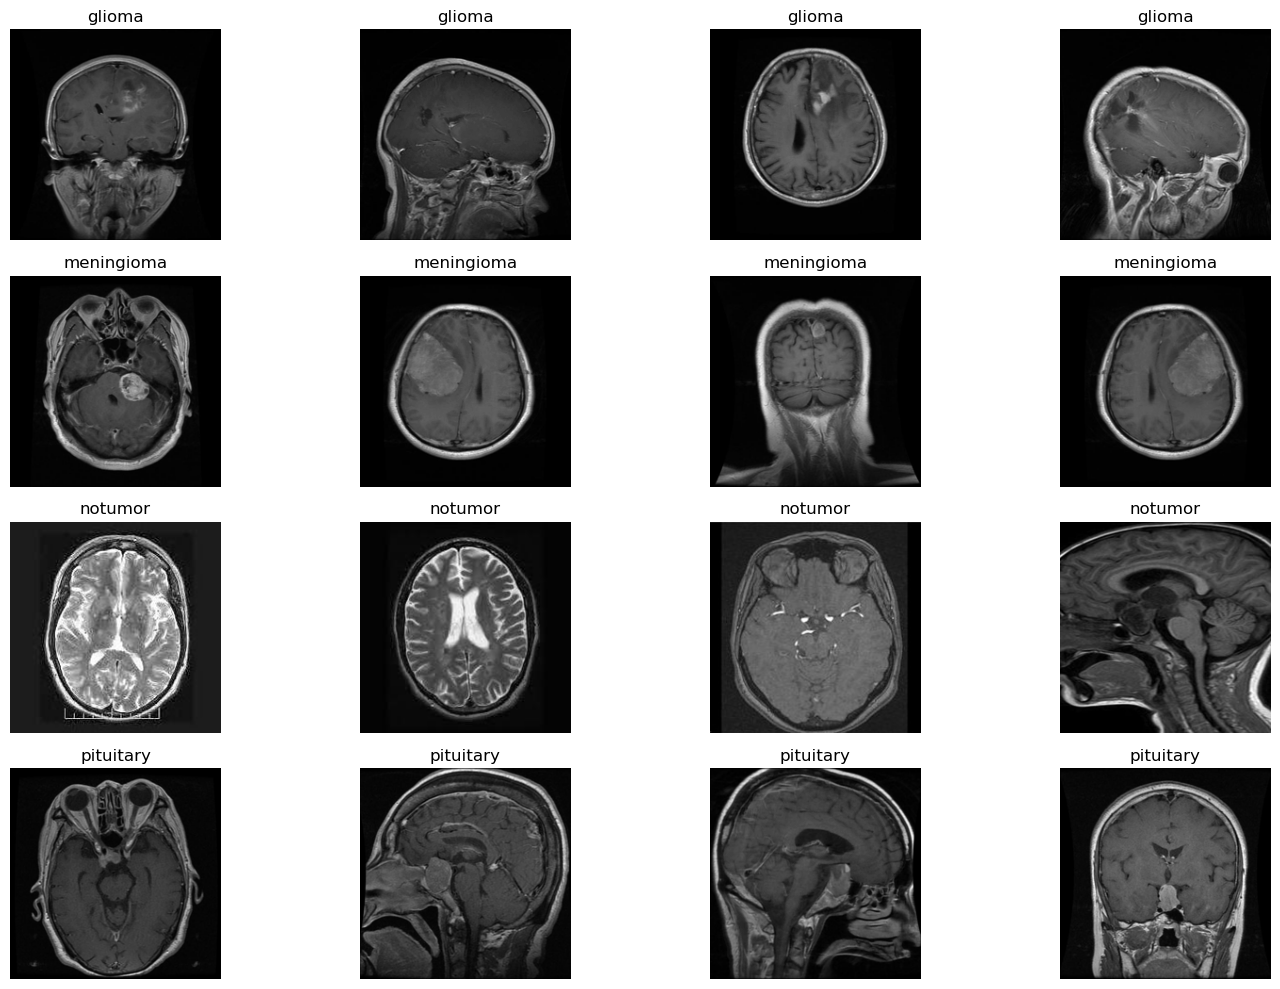

In [11]:
display_images(train)

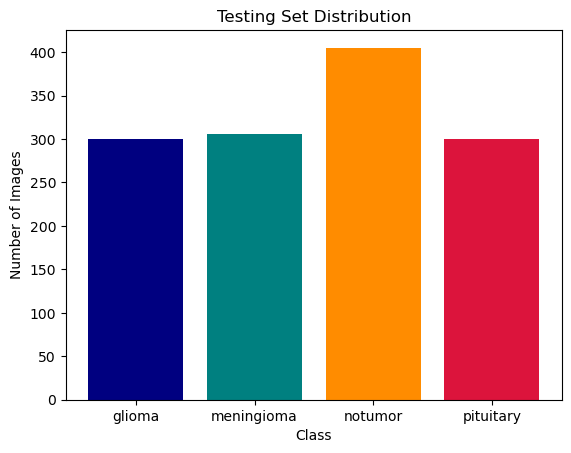

In [21]:
plot_class_distribution(test)

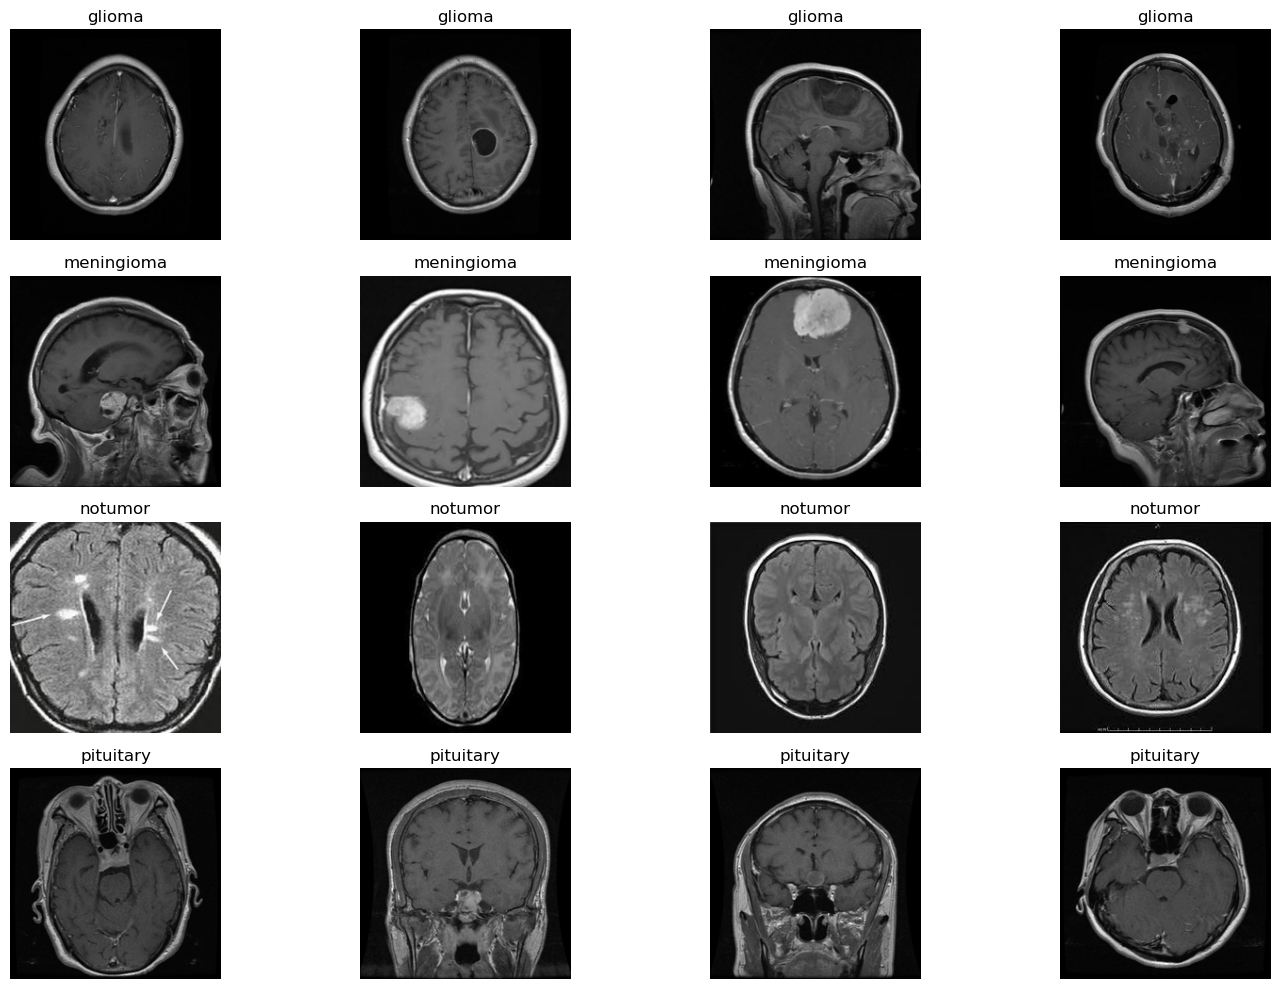

In [23]:
display_images(test)

In [25]:
def create_dataset(path):
    my_list = []
    for category in categories:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])
train_df = create_dataset(base_directory+'/'+train)
test_df = create_dataset(base_directory+'/'+test)
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

# CNN using Pytorch 

In [27]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')  

        if self.transform:
            img = self.transform(img)
            
        return img, label

#Data Augmentation
train_transform = transforms.Compose([

   transforms.Resize(target_size),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
test_df_split, val_df_split = train_test_split(test_df, test_size=0.5, random_state=random_state)
# Reset indices for consistency
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df_split, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B, 32, 224, 224)

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B, 64, 112, 112)

        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B, 128, 56, 56)

        # Conv Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (B, 256, 28, 28)

        # Conv Block 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # (B, 256, 14, 14)

        # Final shape after pool: (B, 256, 7, 7)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (B, 32, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # (B, 64, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # (B, 128, 28, 28)
        x = self.pool(self.relu(self.conv4(x)))  # (B, 256, 14, 14)
        x = self.pool(self.relu(self.conv5(x)))  # (B, 256, 7, 7)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x
model = BrainTumorCNN(num_classes=4).to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0  
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history

In [35]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")
    
    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [37]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Starting training...
Epoch [1/30]
Train Loss: 1.0184, Train Accuracy: 54.92%
Val Loss: 0.8116, Val Accuracy: 69.21%
################################################################################
Epoch [2/30]
Train Loss: 0.6695, Train Accuracy: 72.99%
Val Loss: 0.6663, Val Accuracy: 69.21%
################################################################################
Epoch [3/30]
Train Loss: 0.5314, Train Accuracy: 80.23%
Val Loss: 0.4798, Val Accuracy: 79.88%
################################################################################
Epoch [4/30]
Train Loss: 0.4006, Train Accuracy: 85.19%
Val Loss: 0.3734, Val Accuracy: 84.45%
################################################################################
Epoch [5/30]
Train Loss: 0.3393, Train Accuracy: 87.75%
Val Loss: 0.3296, Val Accuracy: 86.59%
################################################################################
Epoch [6/30]
Train Loss: 0.3208, Train Accuracy: 88.67%
Val Loss: 0.3912, Val Accuracy: 85.52%
####

In [38]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

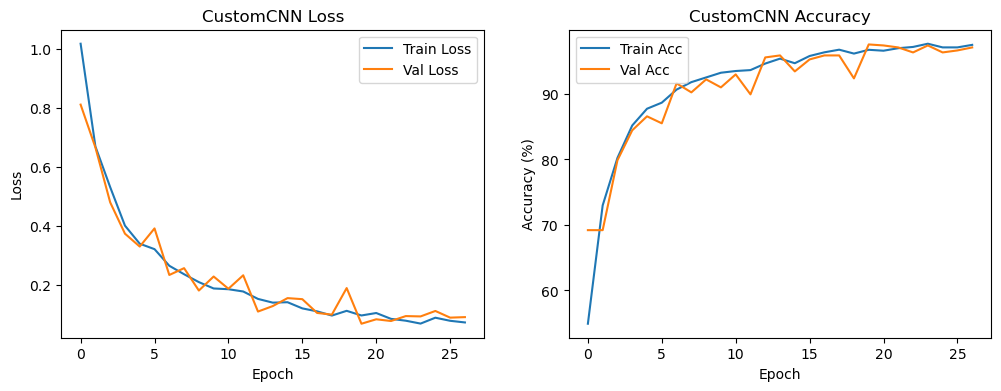

In [39]:
plot_training_history(history, model_name="CustomCNN")


Loading best model for testing...
Test Accuracy: 98.32%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      1.00      1.00       213
  meningioma       0.99      0.98      0.99       149
     notumor       0.99      0.94      0.97       142
   pituitary       0.96      1.00      0.98       151

    accuracy                           0.98       655
   macro avg       0.98      0.98      0.98       655
weighted avg       0.98      0.98      0.98       655



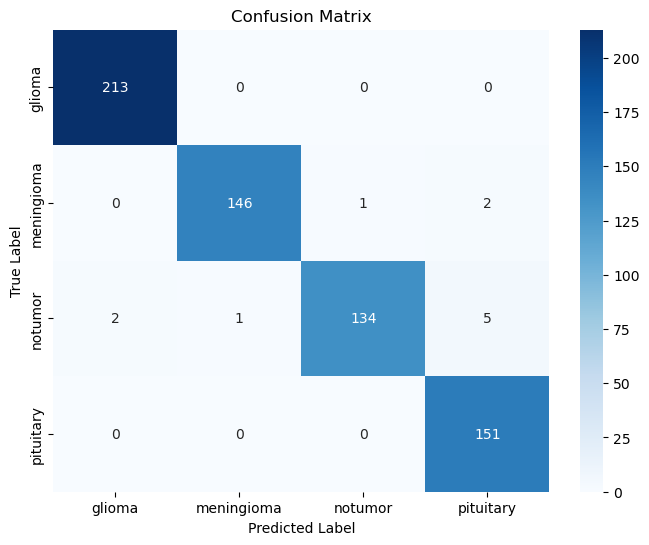

In [40]:
print("\nLoading best model for testing...")
test_model(model, test_loader)

In [41]:
# Save model
model_path = "CNN_best_brain_tumor_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to CNN_best_brain_tumor_model.pth


# Brain Tumor Segmentation using U-Net architecture

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Basic Settings
base_directory = 'Dataset'
train_dir = os.path.join(base_directory, 'Training')
test_dir = os.path.join(base_directory, 'Testing')
target_size = (224, 224)
batch_size = 32
num_classes = 4
random_state = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}


In [3]:
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [5]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


C:\Users\smil\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\smil\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\smil/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 10.6MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

best_accuracy = 0.0
EPOCHS = 10
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_brain_tumor_model.pt')
        print(f"Best model saved with accuracy: {accuracy:.2f}%")


Epoch 1/10, Loss: 0.2209, Accuracy: 92.30%
Best model saved with accuracy: 92.30%
Epoch 2/10, Loss: 0.0361, Accuracy: 98.95%
Best model saved with accuracy: 98.95%
Epoch 3/10, Loss: 0.0256, Accuracy: 99.25%
Best model saved with accuracy: 99.25%
Epoch 4/10, Loss: 0.0119, Accuracy: 99.65%
Best model saved with accuracy: 99.65%
Epoch 5/10, Loss: 0.0132, Accuracy: 99.61%
Epoch 6/10, Loss: 0.0243, Accuracy: 99.21%
Epoch 7/10, Loss: 0.0167, Accuracy: 99.54%
Epoch 8/10, Loss: 0.0048, Accuracy: 99.91%
Best model saved with accuracy: 99.91%
Epoch 9/10, Loss: 0.0046, Accuracy: 99.88%
Epoch 10/10, Loss: 0.0026, Accuracy: 99.98%
Best model saved with accuracy: 99.98%


In [8]:
model.load_state_dict(torch.load('best_brain_tumor_model.pt'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred = probs.argmax(1).item()
        all_preds.append(pred)
        all_labels.append(labels.item())

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))



Classification Report:

              precision    recall  f1-score   support

     notumor       1.00      0.97      0.98       300
      glioma       0.97      0.99      0.98       306
  meningioma       1.00      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



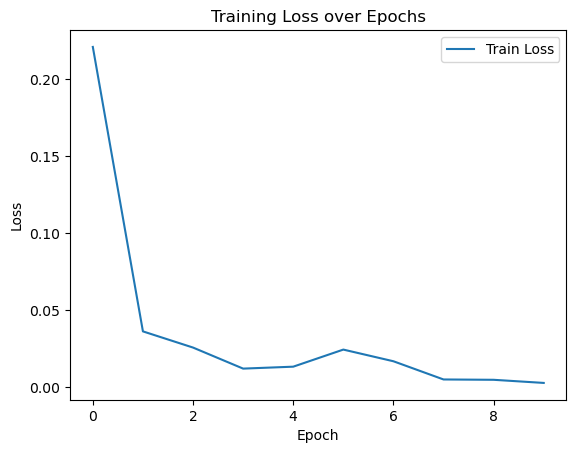

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve.png")
plt.show()
